In [1]:
import numpy as np
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from yellowbrick.cluster import SilhouetteVisualizer

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%matplotlib inline
%config IPCompleter.use_jedi = False

In [2]:
df_hist = pd.read_parquet('../data/processed/HistoricoVentas.parquet', engine='pyarrow')
print(df_hist.shape)
df_hist.head()

(554466, 4)


,Mes,Subagencia,SKU,Hectolitros
0,2013-01-01,10197,00000001,48.028901
1,2013-01-01,10203,00000001,2.524817
2,2013-01-01,10198,00000001,3.500314
3,2013-01-01,10204,00000001,8.549948
4,2013-01-01,10199,00000001,6.484189


In [3]:
df_total_skus = df_hist.groupby('SKU', as_index=False).Hectolitros.sum().sort_values('Hectolitros')
skus_cero = df_total_skus[df_total_skus.Hectolitros == 0].SKU.unique()

df_hist_filtrado = df_hist.loc[~df_hist.SKU.isin(skus_cero)]
print(df_hist_filtrado.shape)
df_hist_filtrado.head()

(352780, 4)


,Mes,Subagencia,SKU,Hectolitros
0,2013-01-01,10197,00000001,48.028901
1,2013-01-01,10203,00000001,2.524817
2,2013-01-01,10198,00000001,3.500314
3,2013-01-01,10204,00000001,8.549948
4,2013-01-01,10199,00000001,6.484189


In [4]:
df_matriz = df_hist_filtrado.groupby(['Subagencia', 'SKU'], as_index=False).Hectolitros.sum()
df_matriz = df_matriz.pivot(index='Subagencia', columns='SKU', values='Hectolitros').fillna(0)
df_matriz.head()

SKU,00000001,00000002,00000005,00000025,00000026,00000027,00000028,00000029,00000030,00000031,00000032,00000033,00000034,00000035,00000036,00000037,00000038,00000039,00000040,00000041,00000042,00000043,00000044,00000045,00000046,00000048,00000049,00000050,00000051,00000069,00000070,00000072,00000073,00000074,00000075,00000076,00000077,00000078,00000080,00000081,00000082,00000083,00000084,00000085,00000087,00000090,00000094,00000096,00000097,00000098,...,00000218,00000231,00000232,00000239,00000240,00000241,00000242,00000243,00000245,00000250,00000251,00000253,00000255,00000257,00000258,00000259,00000261,00000263,00000264,00000266,00000267,00000271,00000273,00000276,00000277,00000278,00000279,00000280,00000281,00000284,00000285,00000286,00000288,00000289,00000290,00000291,00000292,00000293,00000295,00000296,00000297,00000300,00000301,00000302,00000303,00000304,00000305,00000306,00000307,00000308
Subagencia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10003,2813.646197,0.0,0.0,525.847248,0.0,0.0,3281.877945,0.000000,475.512552,0.0,159.877046,0.0,0.0,0.0,1295.329080,1131.189991,7471.892110,1358.210812,0.0,0.0,0.0,10982.910919,1669.581042,7342.975185,57942.868276,0.0,0.0,1550.351673,9309.591144,0.0,0.0,0.00000,0.000000,0.057382,0.000000,2950.840303,3157.184673,159.428899,2330.060536,1330.436749,0.000000,0.000000,0.0,4776.104776,525.474668,9625.758984,0.0,754.999966,0.0,6381.644184,...,0.0,2410.299911,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,29.237982,0.0,0.000000,0.0,0.0,0.0,25.460859,0.000000,0.000000,16.067016,0.0,0.0,0.0,0.0,3060.992844,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,201.296758,0.0,1138.175937,4655.219877,113521.303404,0.0,10869.668629,0.0,44392.209916,109.101275,3571.626131,46086.498440,166.349381,453.597805,0.000000,0.0,0.0
10005,342.707512,0.0,0.0,79.429896,0.0,0.0,94.337145,0.000000,84.473064,0.0,27.191485,0.0,0.0,0.0,8.398545,49.226519,110.669789,8.835916,0.0,0.0,0.0,6257.958738,515.699219,907.470128,2129.888523,0.0,0.0,225.253826,4332.055450,0.0,0.0,0.00000,0.000000,3.787225,0.000000,278.421398,1208.164710,18.878744,111.369152,78.751008,0.000000,0.000000,0.0,58.127360,94.531652,735.429672,0.0,81.929254,0.0,157.308048,...,0.0,247.899186,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,7.536600,0.0,0.000000,0.0,0.0,0.0,0.172147,0.000000,0.000000,6.426806,0.0,0.0,0.0,0.0,936.453258,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,403.339484,6850.492117,61284.358514,0.0,1851.002006,0.0,3726.381883,29.984557,377.111373,1077.666946,21.620158,23.923798,0.000000,0.0,0.0
10006,57416.571668,0.0,0.0,144388.227456,0.0,0.0,1944.946770,2026.452393,44938.312272,0.0,4830.869081,0.0,0.0,0.0,1949.634330,0.000000,0.000000,0.000000,0.0,0.0,0.0,49.574449,62.934803,0.000000,72.420916,0.0,0.0,0.000000,0.000000,0.0,0.0,142.18932,2858.506416,0.000000,235.070627,388724.377548,274311.718715,37537.711888,0.000000,0.000000,6336.726314,62.671869,0.0,0.000000,17454.812454,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,158.655048,0.0,0.0,0.0,0.0,1681.916194,0.0,0.0,16.648516,0.0,439.173994,0.0,0.0,0.0,2776.500248,80.952343,84.868274,0.000000,0.0,0.0,0.0,0.0,97594.546608,0.0,4083.486400,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,1525.843749,0.0,410.959328,0.0,0.000000,760.828704,27825.196002,140.069142,2353.795214,1051.933723,1163.262600,0.0,0.0
10007,9318.802199,0.0,0.0,37090.560960,0.0,0.0,369.926610,204.051103,6848.234208,0.0,830.427251,0.0,0.0,0.0,242.971860,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,20.770875,0.000000,15.093674,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,411.600096,51.586598,0.000000,150620.630506,52873.852558,3282.432909,0.000000,0.000000,4387.239346,88.150374,0.0,0.000000,2131.984724,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,36.022686,0.0,0.0,0.0,0.0,88.741438,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,162.618865,27.442768,34.658849,0.000000,0.0,0.0,0.0,0.0,27214.037721,0.0,73.631330,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,221.4257

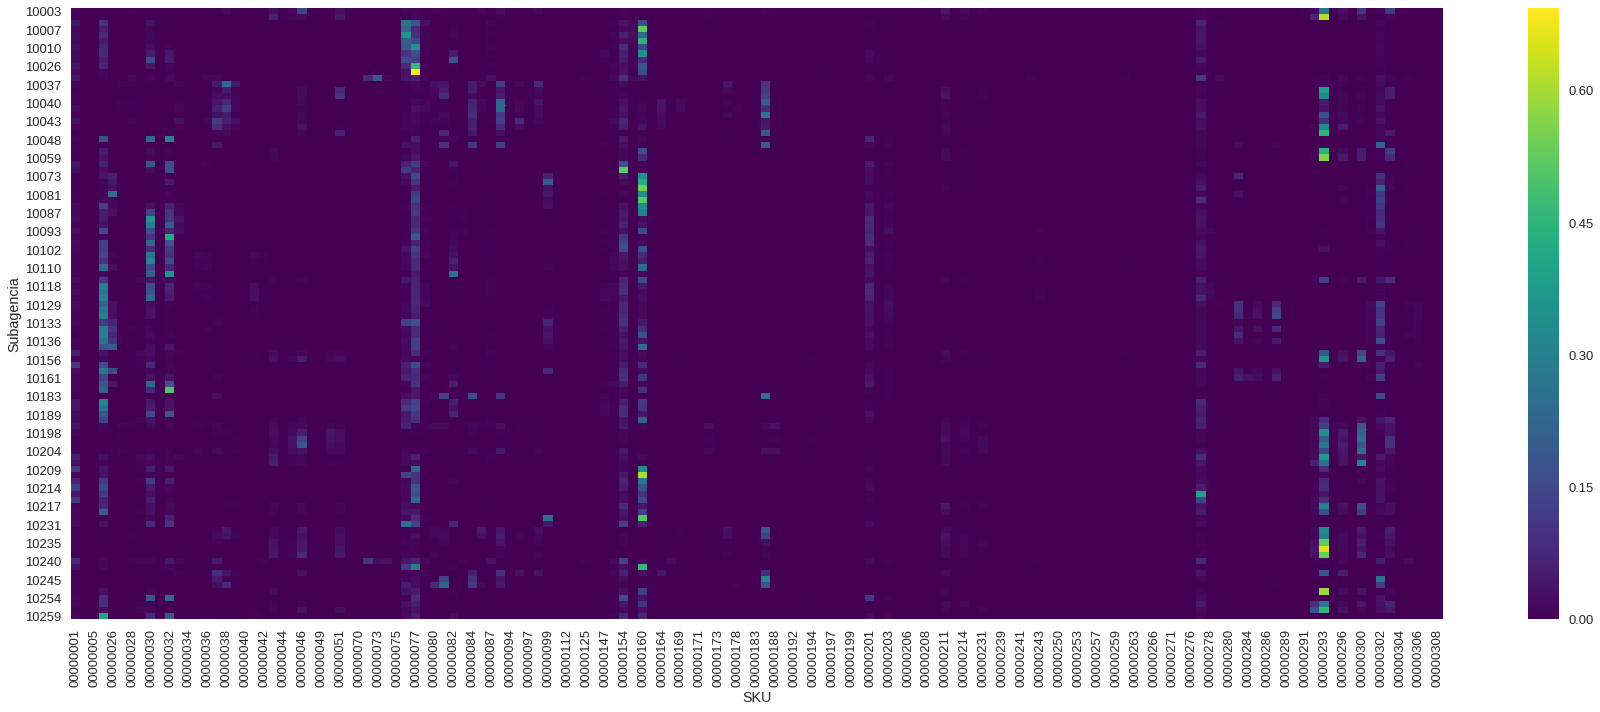

In [93]:
with plt.style.context('seaborn-talk'):
    import seaborn as sns
    df_aux = df_matriz.divide(df_matriz.sum(axis=1), axis=0)
    fig, ax = plt.subplots(1, 1, figsize=(25, 10))
    sns.heatmap(df_aux, ax=ax, cmap='viridis')
    plt.tight_layout()

In [6]:
pca = PCA(n_components=20)
pca.fit(df_aux)

X_proj = pca.transform(df_aux)
df_proj = pd.DataFrame(X_proj, index=df_aux.index)
X_proj.shape

(100, 20)

In [92]:
df_catalogo.reset_index().to_csv('../data/processed/catalogo_cluster.csv', index=False, quoting=1, encoding='utf-8')

In [7]:



# visualizer = KElbowVisualizer(SpectralClustering(), k=(2, 12))
# visualizer.fit(X_proj) # Fit the training data to the visualizer
# visualizer.poof() # Draw/show/poof the data

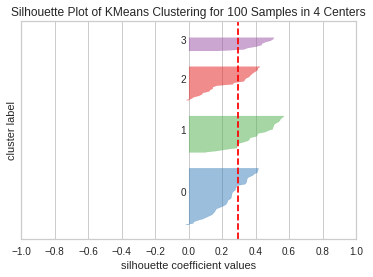

In [8]:
n_clusters = 4

visualizer = SilhouetteVisualizer(KMeans(n_clusters=n_clusters), )

visualizer.fit(X_proj) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

In [9]:
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(df_proj)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
df_cluster = df_proj.assign(cluster=kmeans.labels_)
df_cluster.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,cluster
Subagencia,,,,,,,,,,,,,,,,,,,,,
10003,0.270625,0.006543,-0.002714,0.003002,-0.000357,0.066352,-0.078376,0.007486,0.034384,-0.005050,-0.024913,0.018771,-0.004758,0.027393,0.003750,0.097070,-0.033856,0.020798,-0.041559,0.016819,1
10005,0.507976,0.085821,-0.143620,-0.001998,0.014730,-0.062178,0.067730,0.010553,-0.036006,-0.018953,0.009059,0.032797,-0.019683,-0.003161,-0.013485,-0.024508,0.013607,-0.002677,0.007171,-0.014188,1
10006,-0.158065,0.076466,0.018469,-0.047782,0.132897,0.086880,0.076179,-0.095668,0.045871,-0.047958,0.041744,0.036653,-0.011967,-0.017468,-0.047134,0.009537,-0.002925,-0.010058,-0.003188,0.012637,2
10007,-0.244360,0.347769,-0.008048,0.040489,-0.077232,0.098223,0.085829,-0.091867,0.050448,-0.018503,0.014362,-0.004914,-0.018400,-0.026631,-0.008143,0.015584,-0.000878,-0.012346,0.014716,-0.006438,2
10008,-0.166133,0.137504,0.030375,-0.022504,0.068547,0.180819,0.153282,-0.115230,0.059127,-0.082642,0.038711,0.044950,-0.017332,-0.028460,-0.052427,0.012526,-0.007367,-0.012199,0.000417,0.009415,2


In [11]:
df_catalogo = pd.read_parquet('../data/processed/Catalogo_Subagencias.parquet', engine='pyarrow').set_index('Subagencia')
df_catalogo = df_catalogo.join(df_cluster[['cluster']])
df_catalogo.head()

,Desc_Subagencia,Latitud,Longitud,cluster
Subagencia,,,,
10197,CMM M Tijuana,32.483126,-116.949128,1
10203,CMM San Luis,32.448203,-114.775272,1
10198,CMM Peñasco,31.419830,-113.412489,1
10204,CMM Ensenada,31.850329,-116.611457,1
10199,CMM Mexicali,32.515571,-115.388674,1


In [12]:
df_catalogo.cluster.value_counts()

0    44
1    26
2    20
3    10
Name: cluster, dtype: int64

In [28]:
df_grupos = df_aux.join(df_catalogo[['cluster']])
df_grupos.head()

,00000001,00000002,00000005,00000025,00000026,00000027,00000028,00000029,00000030,00000031,00000032,00000033,00000034,00000035,00000036,00000037,00000038,00000039,00000040,00000041,00000042,00000043,00000044,00000045,00000046,00000048,00000049,00000050,00000051,00000069,00000070,00000072,00000073,00000074,00000075,00000076,00000077,00000078,00000080,00000081,00000082,00000083,00000084,00000085,00000087,00000090,00000094,00000096,00000097,00000098,...,00000231,00000232,00000239,00000240,00000241,00000242,00000243,00000245,00000250,00000251,00000253,00000255,00000257,00000258,00000259,00000261,00000263,00000264,00000266,00000267,00000271,00000273,00000276,00000277,00000278,00000279,00000280,00000281,00000284,00000285,00000286,00000288,00000289,00000290,00000291,00000292,00000293,00000295,00000296,00000297,00000300,00000301,00000302,00000303,00000304,00000305,00000306,00000307,00000308,cluster
Subagencia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10003,0.006861,0.0,0.0,0.001282,0.0,0.0,0.008003,0.000000,0.001160,0.0,0.000390,0.0,0.0,0.0,0.003159,0.002758,0.018220,0.003312,0.0,0.0,0.0,0.026781,0.004071,0.017906,0.141291,0.0,0.0,0.003780,0.022701,0.0,0.0,0.000000,0.000000,1.399239e-07,0.000000,0.007195,0.007699,0.000389,0.005682,0.003244,0.000000,0.000000,0.0,0.011646,0.001281,0.023472,0.0,0.001841,0.0,0.015561,...,0.005877,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000071,0.0,0.000000,0.0,0.0,0.0,0.000062,0.000000,0.000000,0.000039,0.0,0.0,0.0,0.0,0.007464,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000491,0.0,0.002775,0.011352,0.276816,0.0,0.026505,0.0,0.108248,0.000266,0.008709,0.112380,0.000406,0.001106,0.000000,0.0,0.0,1
10005,0.003444,0.0,0.0,0.000798,0.0,0.0,0.000948,0.000000,0.000849,0.0,0.000273,0.0,0.0,0.0,0.000084,0.000495,0.001112,0.000089,0.0,0.0,0.0,0.062892,0.005183,0.009120,0.021405,0.0,0.0,0.002264,0.043537,0.0,0.0,0.000000,0.000000,3.806139e-05,0.000000,0.002798,0.012142,0.000190,0.001119,0.000791,0.000000,0.000000,0.0,0.000584,0.000950,0.007391,0.0,0.000823,0.0,0.001581,...,0.002491,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000076,0.0,0.000000,0.0,0.0,0.0,0.000002,0.000000,0.000000,0.000065,0.0,0.0,0.0,0.0,0.009411,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.004054,0.068847,0.615904,0.0,0.018602,0.0,0.037450,0.000301,0.003790,0.010830,0.000217,0.000240,0.000000,0.0,0.0,1
10006,0.039070,0.0,0.0,0.098252,0.0,0.0,0.001323,0.001379,0.030579,0.0,0.003287,0.0,0.0,0.0,0.001327,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000034,0.000043,0.000000,0.000049,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000097,0.001945,0.000000e+00,0.000160,0.264516,0.186661,0.025543,0.000000,0.000000,0.004312,0.000043,0.0,0.000000,0.011878,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000108,0.0,0.0,0.0,0.0,0.001144,0.0,0.0,0.000011,0.0,0.000299,0.0,0.0,0.0,0.001889,0.000055,0.000058,0.000000,0.0,0.0,0.0,0.0,0.066410,0.0,0.002779,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.001038,0.0,0.000280,0.0,0.000000,0.000518,0.018934,0.000095,0.001602,0.000716,0.000792,0.0,0.0,2
10007,0.013719,0.0,0.0,0.054602,0.0,0.0,0.000545,0.000300,0.010082,0.0,0.001223,0.0,0.0,0.0,0.000358,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000031,0.000000,0.000022,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000606,7.594243e-05,0.000000,0.221734,0.077837,0.004832,0.000000,0.000000,0.006459,0.000130,0.0,0.000000,0.003139,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000053,0.0,0.0,0.0,0.0,0.000131,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000239,0.000040,0.000051,0.000000,0.0,0.0,0.0,0.0,0.040063,0.0,0.000108,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000326,0.0,0.000057,0.0,0.000000,0.000220,0.007987,0.000051,0.001405,0.000110,0.000245,0.0,0.0,2
10008,0.018275,0.0,0.0,0.077841,0.0,0.0,0.000793,0.001358,0.009283,0.0,0.002630,0.0,0.0,0.0,0.000698,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000036,0.000000,0.000000,0.000063,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000880,0.000000

In [73]:
columnas_up = []
columnas_down = []
for cluster, sub_df in df_grupos.groupby('cluster'):
    df_agg = sub_df.drop('cluster', axis=1).mean().sort_values(ascending=False)
    columnas_up.extend(list(df_agg.head(5).index.values))
    columnas_down.extend(list(df_agg.tail(5).index.values))
    

    

In [86]:
columnas_up_aux = []
for c in columnas_up:
    if c in columnas_up_aux:
        continue
    columnas_up_aux.append(c)
    
columnas_down_aux = []
for c in columnas_down:
    if c in columnas_down_aux:
        continue
    columnas_down_aux.append(c)
columnas_down_aux.pop()

'00000198'

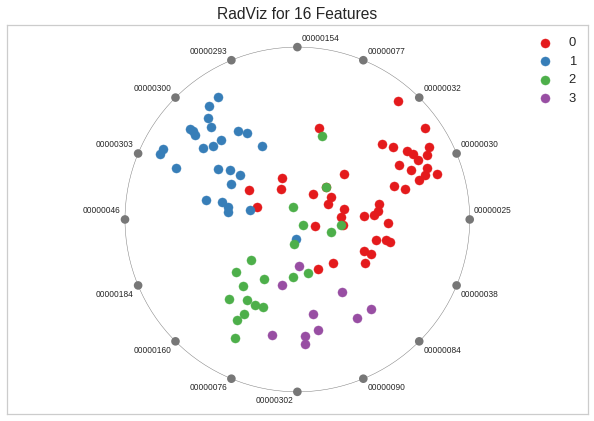

In [89]:
from yellowbrick.features import RadViz


with plt.style.context('seaborn-talk'): 
    X = df_grupos[(columnas_up_aux)].values
    y = df_grupos['cluster'].values
    visualizer = RadViz(classes=[0, 1, 2, 3], features=columnas_up_aux, color=['#e41a1c','#377eb8','#4daf4a','#984ea3'])
    visualizer.fit(X, y)
    visualizer.transform(X)
    visualizer.poof() 

In [59]:
RadViz?

Init signature: RadViz(ax=None, features=None, classes=None, color=None, colormap=None, **kwargs)
Docstring:     
RadViz is a multivariate data visualization algorithm that plots each
axis uniformely around the circumference of a circle then plots points on
the interior of the circle such that the point normalizes its values on
the axes from the center to each arc.

Parameters
----------

ax : matplotlib Axes, default: None
    The axis to plot the figure on. If None is passed in the current axes
    will be used (or generated if required).

features : list, default: None
    a list of feature names to use
    If a DataFrame is passed to fit and features is None, feature
    names are selected as the columns of the DataFrame.

classes : list, default: None
    a list of class names for the legend
    If classes is None and a y value is passed to fit then the classes
    are selected from the target vector.

color : list or tuple, default: None
    optional list or tuple of colors to co

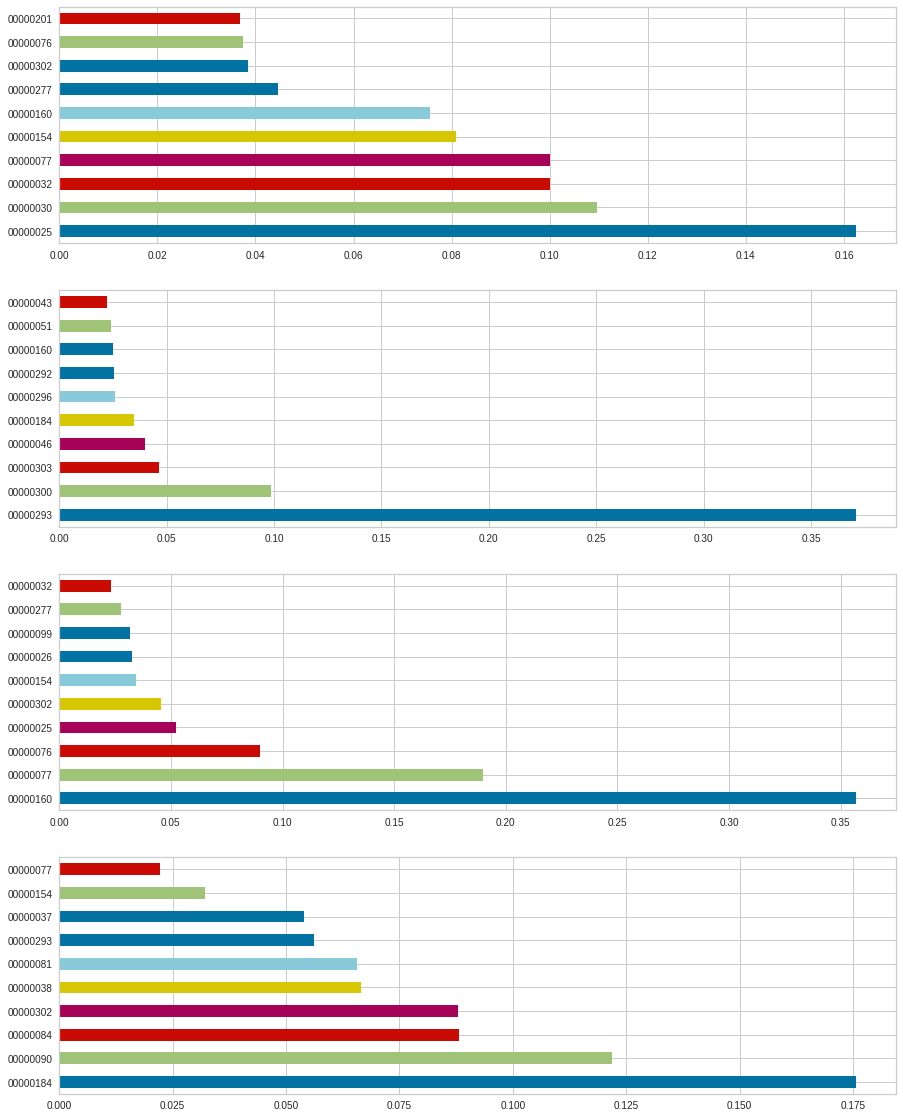

In [41]:
fig, axs = plt.subplots(4, 1, figsize=(15, 20))
for (cluster, sub_df), ax in zip(df_grupos.groupby('cluster'), axs.flatten()):
    sub_df.drop('cluster', axis=1).mean().sort_values(ascending=False).head(10).plot.barh(ax=ax)


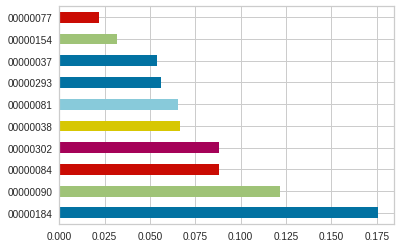

In [36]:
ub_df.drop('cluster', axis=1).mean().sort_values(ascending=False).head(10).plot.barh()

# Mapa

In [17]:
import pyproj
from bokeh.palettes import Viridis256
from bokeh.io import output_notebook, output_file
from bokeh.resources import INLINE
from bokeh.models import WMTSTileSource
from bokeh.plotting import show, figure, ColumnDataSource
from bokeh.models import ColorBar, LinearColorMapper, HoverTool, ColumnDataSource
output_notebook(INLINE)

def wgs84_to_web_mercator(latitudes, longitudes, inproj: str = 'epsg:4326',
                          outproj: str = 'epsg:3857') -> tuple:
    """Utility function to transform longitude and latitude values
    to web marcator values"""
    output =  pyproj.transform(pyproj.Proj(init=inproj), pyproj.Proj(init=outproj), longitudes, latitudes)
    # reverse the output
    return output[::-1]

Loading BokehJS ...

In [21]:
cluster_color = {
    k: c
    for k, c in zip(df_catalogo.cluster.unique(), ['#e41a1c','#377eb8','#4daf4a','#984ea3'])
}
cluster_color

{1: '#e41a1c', 2: '#377eb8', 0: '#4daf4a', 3: '#984ea3'}

In [22]:
y, x = wgs84_to_web_mercator(df_catalogo.Latitud.values, df_catalogo.Longitud.values)
df_map = df_catalogo.reset_index().assign(y=y, x=x)
df_map = df_map.assign(color=df_map.cluster.map(cluster_color))

df_map.head()

,Subagencia,Desc_Subagencia,Latitud,Longitud,cluster,y,x,color
0,10197,CMM M Tijuana,32.483126,-116.949128,1,3.826897e+06,-1.301872e+07,#e41a1c
1,10203,CMM San Luis,32.448203,-114.775272,1,3.822289e+06,-1.277672e+07,#e41a1c
2,10198,CMM Peñasco,31.419830,-113.412489,1,3.687393e+06,-1.262502e+07,#e41a1c
3,10204,CMM Ensenada,31.850329,-116.611457,1,3.743680e+06,-1.298113e+07,#e41a1c
4,10199,CMM Mexicali,32.515571,-115.388674,1,3.831179e+06,-1.284501e+07,#e41a1c


In [25]:



x_range, y_range = wgs84_to_web_mercator(np.array((-117, -86)), np.array((14.32, 32.38)))
x_range = (x_range[0], x_range[1])
y_range = (y_range[0], y_range[1])

p = figure(output_backend='webgl', title='Clusters', plot_width=1200, plot_height=900,
           x_range=x_range, y_range=y_range, toolbar_location='right')
p.axis.visible = False
wikipedia_tiles = WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png')
p.add_tile(wikipedia_tiles)

source = ColumnDataSource(df_map.loc[:, ['x', 'y', 'color', 'Subagencia', 'Desc_Subagencia']])

p.circle(x='x', y='y', color='color', size=10, alpha=0.9, source=source)

tooltips = [
    ('Subagencia', '@Subagencia'),
]
hover = HoverTool(tooltips=tooltips)

p.add_tools(hover)


# puntos denue

# source_puntos = ColumnDataSource(
#     df_puntos.loc[:, ['x', 'y', 'color', 'codigo_act', 'cvegeo', 'nombre_act', 'color', 'nom_estab', 'per_ocu']]
# )

# p.circle(x='x', y='y', color='color', alpha=0.5, source=source_puntos)

# # tooltips_puntos = [
# #     ('nombre_act', '@nombre_act'), 
# #     ('per_ocu', '@per_ocu')
# # ]
# # hover_puntos = HoverTool(tooltips=tooltips_puntos)

# # p.add_tools(hover_puntos)


show(p)

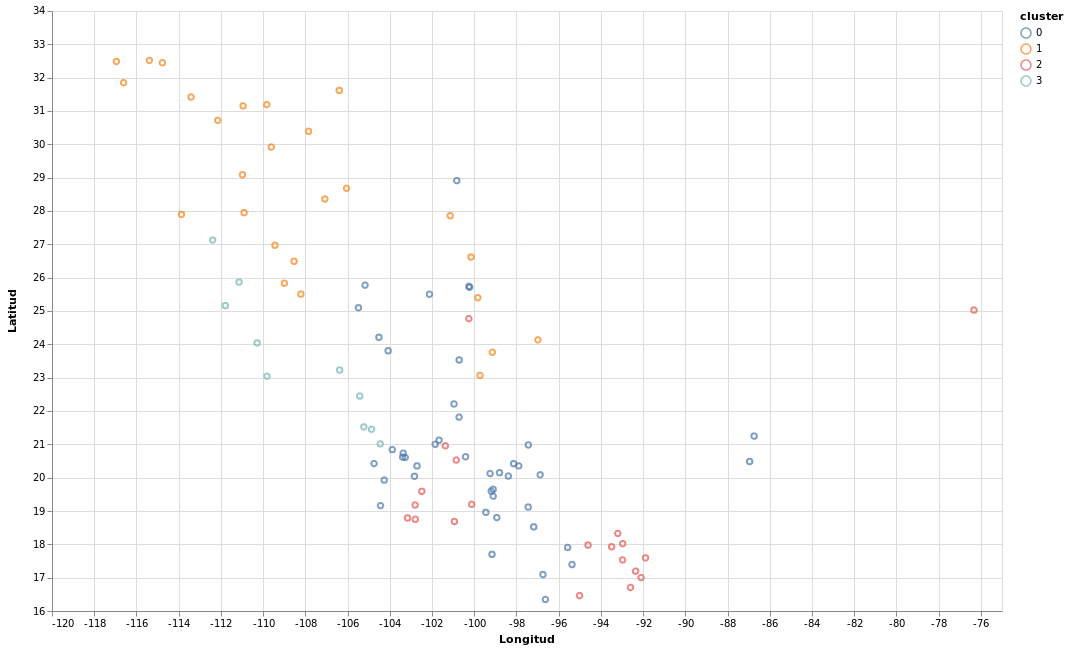

In [13]:
alt.Chart(df_catalogo).mark_point().encode(
    x=alt.X('Longitud', scale=alt.Scale(zero=False)),
    y=alt.Y('Latitud', scale=alt.Scale(zero=False)),
    color='cluster:N'
).properties(
    width=950,
    height=600
)


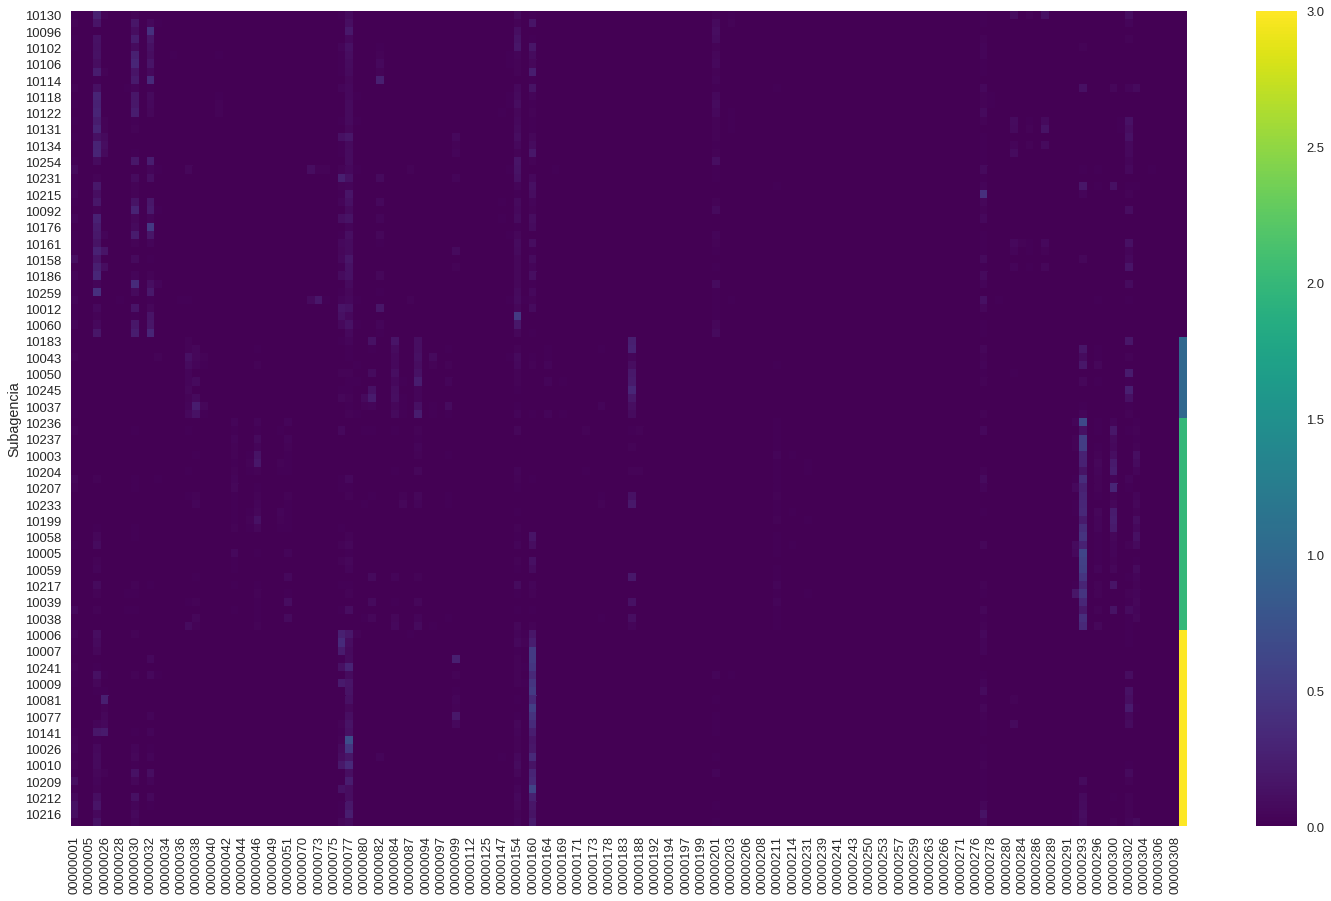

In [29]:
df_heat = df_aux.join(df_cluster[['cluster']]).sort_values('cluster')
with plt.style.context('seaborn-talk'):
    import seaborn as sns
    fig, ax = plt.subplots(1, 1, figsize=(25, 15))
    sns.heatmap(df_heat, ax=ax, cmap='viridis')

In [30]:
df_cluster.cluster.value_counts()

0    40
2    26
3    24
1    10
Name: cluster, dtype: int64

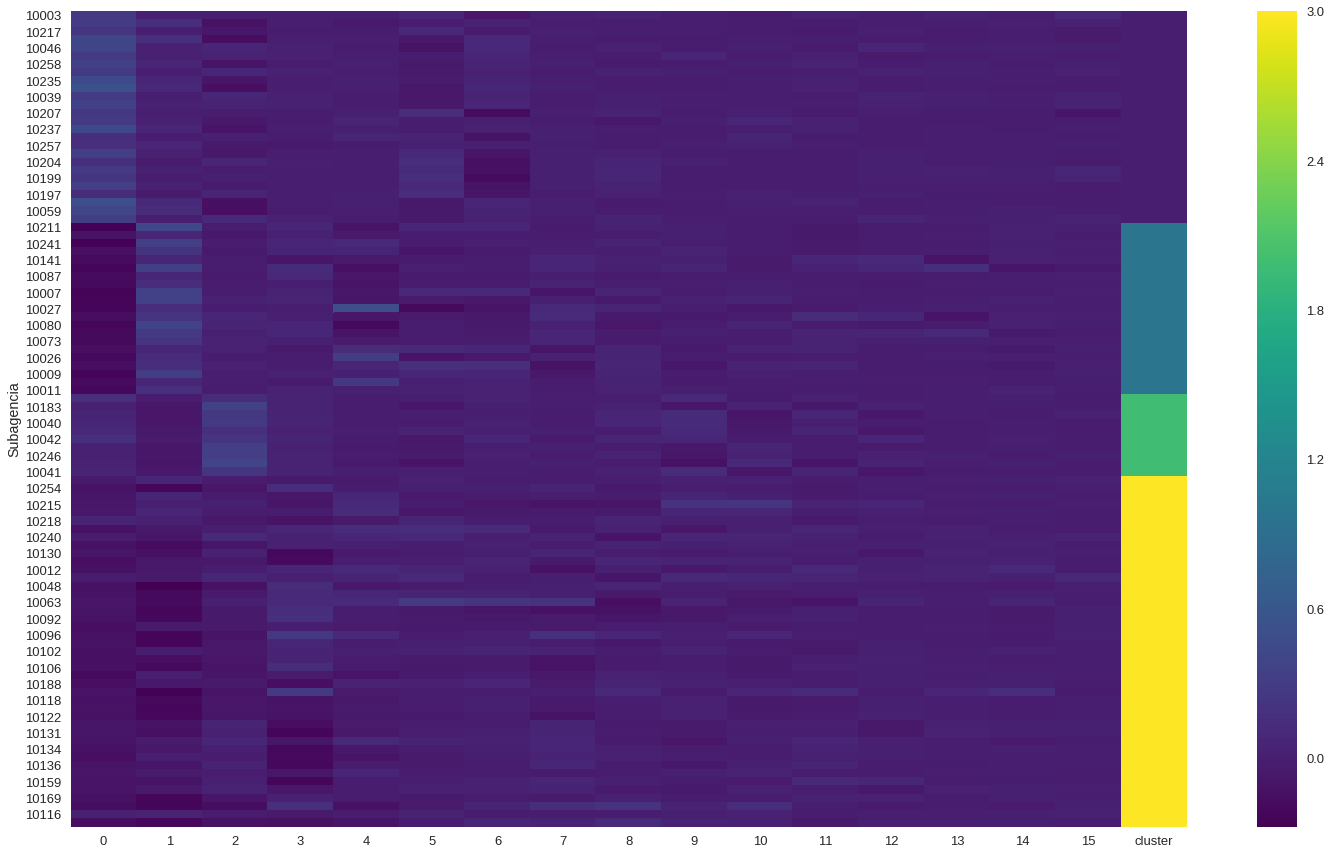

In [64]:
with plt.style.context('seaborn-talk'):
    import seaborn as sns
    fig, ax = plt.subplots(1, 1, figsize=(25, 15))
    sns.heatmap(df_cluster.sort_values('cluster'), ax=ax, cmap='viridis')

In [ ]:
df_box = df_aux.join(df_cluster[['cluster']])

with plt.style.context('seaborn-talk'):
#     import seaborn as sns
    df_box.groupby('cluster').plot.box()

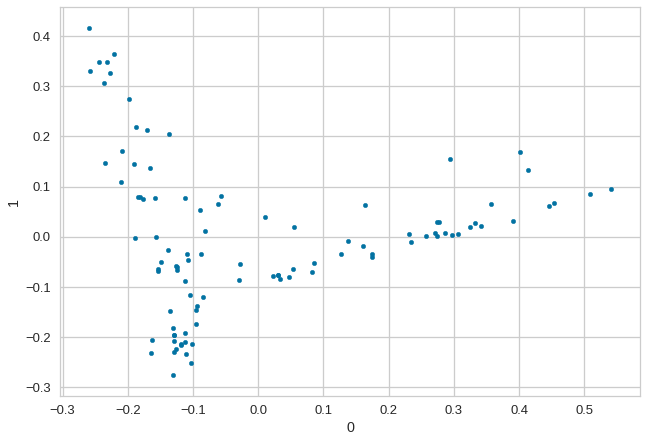

In [13]:
with plt.style.context('seaborn-talk'):
    df_proj = pd.DataFrame(X_proj)
    df_proj.plot.scatter(x=0, y=1)

In [84]:
import hdbscan


clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
cluster_labels = clusterer.fit_predict(df_aux)
pd.Series(cluster_labels).value_counts()

-1    51
 4    21
 2     8
 3     7
 0     7
 1     6
dtype: int64

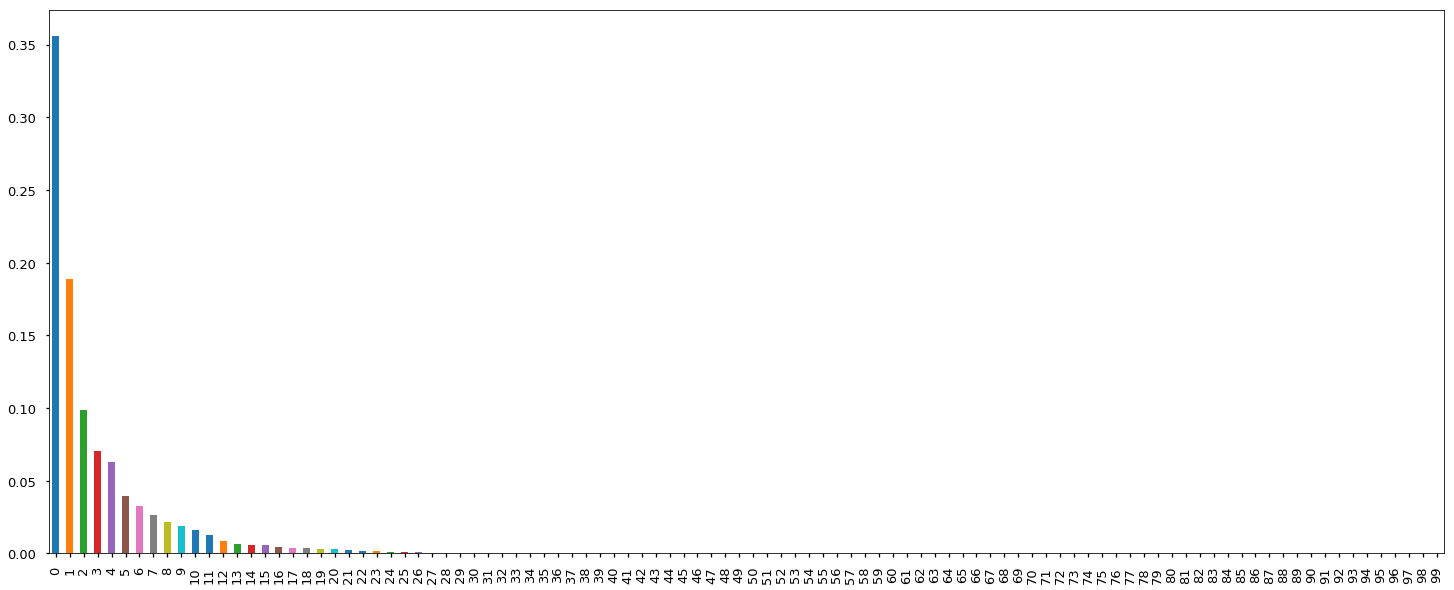

In [66]:
with plt.style.context('seaborn-talk'):
    pd.Series(pca.explained_variance_ratio_).plot.bar(figsize=(25, 10))

In [29]:
# df_hist[df_hist.Subagencia == '10197'].Mes.drop_duplicates().diff()

In [40]:
# df_hist[df_hist.Subagencia == '10197'].sort_values('Mes').groupby(['Mes', 'SKU']).

In [16]:
30 *276

8280

In [13]:
df_hist.Mes.describe()

count                  554466
unique                     62
top       2017-04-01 00:00:00
freq                     8943
first     2013-01-01 00:00:00
last      2018-02-01 00:00:00
Name: Mes, dtype: object

In [11]:
df_total_skus.Hectolitros.describe()

count    2.760000e+02
mean     1.757432e+05
std      6.776218e+05
min      0.000000e+00
25%      0.000000e+00
50%      3.048881e+01
75%      3.164486e+04
max      6.052544e+06
Name: Hectolitros, dtype: float64

In [12]:
df_total_skus[df_total_skus.Hectolitros > 0].shape

(145, 2)

In [3]:
df_catalogo = pd.read_parquet('../data/preprocessed/Catalogo_Subagencias.parquet', engine='pyarrow')
print(df_catalogo.shape)
df_catalogo.head()

(100, 4)


,Subagencia,Desc_Subagencia,Latitud,Longitud
0,10197,CMM M Tijuana,32.483126,-116.949128
1,10203,CMM San Luis,32.448203,-114.775272
2,10198,CMM Peñasco,31.419830,-113.412489
3,10204,CMM Ensenada,31.850329,-116.611457
4,10199,CMM Mexicali,32.515571,-115.388674


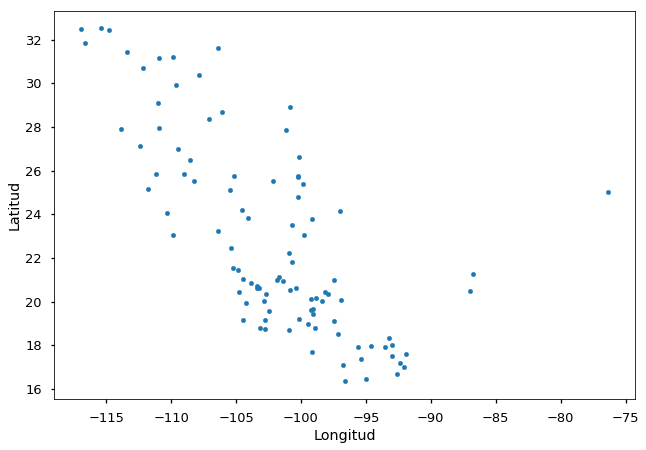

In [4]:
with plt.style.context('seaborn-talk'):
    df_catalogo.plot.scatter(x='Longitud', y='Latitud')